**Imports**

In [1]:
import os
import pandas as pd
import json
import folium
import chardet
import topojson
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

**Question 2:** 
Go to the amstat website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

HINT Go to the details tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through.
Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.

**PART 1: Data analysis of unemployement rates (only concerns registered unemployed people)**

**1- Loading data on unemployement rates by canton in Switzerland** <br>
The following loaded csv file was created through the amstat website https://www.amstat.ch/v2/index.jsp, Details section where we selected the 'Chômeurs et demandeurs d'emploi' folder and then 'Taux de chômage' folder. We are then asked to chose parameters before being given a data file with relative information on the selected parameters. 
Therefore, to produce this first csv file we chose the following parameters:
- Période sous revue sélectionner: 'Mois sous revue'
- Indicateurs taux de chômage: 'Taux de chômage'
- Indicateurs chômeurs: None
- Indicateurs demandeurs d'emploi: None
- Caractéristiques géographiques: 'Canton'
- Optionnel: Restreindre les données géographiques à un ou plusieurs cantons: None
- Autres attributs: None

With these parameters, we are given a data file with information on the unemployement rates by canton which represents the number of registered unemployed people divided by the active population numbers, multiplied by 100. <br><br>
To read the data correctly, we use the character encoding library **chardet**.

In [2]:
unemployement_rates_file = 'data/unemployement_rate_by_canton_switzerland.csv'

with open(unemployement_rates_file, 'rb') as f:
    result = chardet.detect(f.read()) 

unemployement_rates_data = pd.read_csv(unemployement_rates_file, encoding=result['encoding'])

In [3]:
unemployement_rates_data.head()

Canton     Mois   Septembre 2017            Total
0           Mesures  Taux de chômage  Taux de chômage
1   Zurich      NaN              3.3              3.3
2    Berne      NaN              2.4              2.4
3  Lucerne      NaN              1.7              1.7
4      Uri      NaN              0.6              0.6

In [4]:
unemployement_rates_data.dtypes

Canton            object
Mois              object
Septembre 2017    object
Total             object
dtype: object

**2- Unemployement rates data pre processing**
- We drop the columns 'Mois' and 'Total' which are not relevant for our analysis.
- We also drop the first line of the dataframe which contains the index names of some of the columns (we will rename the columns accordingly afterwards).
- After droping the first line, we need to reset the index.
- We rename the remaining columns according to what the numbers represent. In that case: the unemployement rates per canton.
- We finally have to convert the unemployement rates related column to numeric for our analysis

In [5]:
unemployement_rates_data.drop(['Mois', 'Total'], axis=1, inplace = True)

In [6]:
unemployement_rates_data.drop([0,unemployement_rates_data.index.size-1], axis=0, inplace = True)
unemployement_rates_data.reset_index(drop = True, inplace = True)

In [7]:
unemployement_rates_data = unemployement_rates_data.rename(columns={'Septembre 2017' : 'Unemployement rate'})

In [8]:
unemployement_rates_data.head()

Canton Unemployement rate
0   Zurich                3.3
1    Berne                2.4
2  Lucerne                1.7
3      Uri                0.6
4   Schwyz                1.7

In [9]:
unemployement_rates_data['Unemployement rate'] = pd.to_numeric(unemployement_rates_data['Unemployement rate'])

**3- Loading topojson info on swiss cantons' geography**
- First, we get the topojson file on swiss cantons' path.
- Then, we use the **geopandas** library to read the topojson file and display the information it contains.

In [10]:
canton_geo_path = 'topojson/ch-cantons.topojson.json'

In [11]:
canton_geo_df = gpd.read_file(canton_geo_path)
canton_geo_df.head()

id        name                                           geometry
0  ZH      Zürich  POLYGON ((8.807614761476149 47.22089128912891,...
1  BE  Bern/Berne  (POLYGON ((7.824565256525654 47.2658697869787,...
2  LU      Luzern  POLYGON ((8.048666066606661 46.78782398239824,...
3  UR         Uri  POLYGON ((8.934635463546355 46.91997319731973,...
4  SZ      Schwyz  POLYGON ((8.568997299729974 46.98982918291829,...

**4- Mapping french swiss cantons names and their german equivalent**<br>
From the above printed dataframes we can observe that the cantons' names are not matching because the data from the amstat website retrieve most of the cantons' names in their French version while the topojson file has them mostly written in their German one. Nevertheless, we also see that the order of display of the cantons is the same in both dataframes, so we just have to rely on the index to match the names and display them in one and only language. Arbitrarily, we have chosen the German version. 

In [12]:
unemployement_rates_data.Canton = canton_geo_df.name

In [13]:
unemployement_rates_data.Canton.head()

0        Zürich
1    Bern/Berne
2        Luzern
3           Uri
4        Schwyz
Name: Canton, dtype: object

**5- Merging the unemployement rates data and the topojson information on swiss cantons' geography**<br>
We merge the dataframe containg information on the unemployement rates and the geopandas one on the cantons topojson information. To do so, we rely on the name i.e. Cantons' appellation of the dataframes.

In [14]:
merged = canton_geo_df.merge(unemployement_rates_data, left_on='name', right_on='Canton')

In [15]:
merged.head()

id        name                                           geometry  \
0  ZH      Zürich  POLYGON ((8.807614761476149 47.22089128912891,...   
1  BE  Bern/Berne  (POLYGON ((7.824565256525654 47.2658697869787,...   
2  LU      Luzern  POLYGON ((8.048666066606661 46.78782398239824,...   
3  UR         Uri  POLYGON ((8.934635463546355 46.91997319731973,...   
4  SZ      Schwyz  POLYGON ((8.568997299729974 46.98982918291829,...   

       Canton  Unemployement rate  
0      Zürich                 3.3  
1  Bern/Berne                 2.4  
2      Luzern                 1.7  
3         Uri                 0.6  
4      Schwyz                 1.7

**6- Creating a geopandas dataframe with Swiss cantons' names and their respective geometry**<br>
After having created this geopandas dataframe, we convert its content to the json type.

In [16]:
canton_geo_gdf = gpd.GeoDataFrame(merged.iloc[:, [1, 2]])

In [17]:
canton_geo_gdf.head()

name                                           geometry
0      Zürich  POLYGON ((8.807614761476149 47.22089128912891,...
1  Bern/Berne  (POLYGON ((7.824565256525654 47.2658697869787,...
2      Luzern  POLYGON ((8.048666066606661 46.78782398239824,...
3         Uri  POLYGON ((8.934635463546355 46.91997319731973,...
4      Schwyz  POLYGON ((8.568997299729974 46.98982918291829,...

In [18]:
canton_geo_to_json = canton_geo_gdf.to_json()

**7- Creating pop up windows for interactive unemployement rates information on the map**<br>
Indeed, we want the map to be as interactive as possible and make the information retrieved from the amstat website easy to reach and visible. To do so, we will make use of pop up windows which will relate information on the canton's name and its related unemployement rate.<br>
- First, we create a list of texts which contains the name and unemployement rate strings for each canton.
- Secondly, we create the pop up objects delimited by the respective geometry of each canton.

In [19]:
text = []
for i in range(unemployement_rates_data.index.size):
    text.append(unemployement_rates_data.Canton[i] +  '<br>' + 
                'Unemployement rate: ' + str(unemployement_rates_data['Unemployement rate'].loc[i]) + '%')

In [20]:
from shapely.geometry import Polygon, mapping
list_geo=[]
gj=[]
for i in range(canton_geo_gdf.index.size):
     list_geo.append(mapping(canton_geo_gdf['geometry'].loc[i]))
     gj.append(folium.GeoJson(list_geo[i], style_function=lambda feature: {
        'opacity' : 0.7 , 'fillColor': '#FFFFFFFF', 'color' : 'blue'
        }))

**8- Creating choropleth map to display Swiss cantons' unemployement rates information**<br>
- We have chosen the coordinates of the middle of Switzerland to center our map. 
- Then, we initialize our map with these coordinates and make it a choropleth map with the topojson information converted to json in the previous steps after pre processing of the Cantons' names and we use the data on unemployement rates to be displayed accordingly. We use a Yellow (low unemployement rate) to Green (high unemployement rate) sequential color which is by default divided into 6 equal intervals in the range of our unemployement rates values by folium. 
- Finally, we add the above created information strings into the pop up windows before displaying the choropleth map. 

In [21]:
middle_of_switzerland_coord = [46.801111, 8.226667]

In [22]:
swiss_map_unemployement_rates = folium.Map(middle_of_switzerland_coord, tiles='cartodbpositron', zoom_start = 8)

In [23]:
swiss_map_unemployement_rates.choropleth(geo_data=canton_geo_to_json,
              data=unemployement_rates_data, columns=['Canton', 'Unemployement rate'],
                     key_on='feature.properties.name', fill_color='YlGn', fill_opacity=1, line_opacity=0.2,
             legend_name='Unemployment Rate (%)')

In [24]:
for i in range(canton_geo_df.index.size):
    gj[i].add_child(folium.Popup(text[i]))
    gj[i].add_to(swiss_map_unemployement_rates)

In [25]:
swiss_map_unemployement_rates


**10- We save the above map to an html adress. In that case: ...**

In [26]:
swiss_map_unemployement_rates.save(os.path.join('maps', 'unemployement_rates_by_canton.html'))

**11- Histogram of unemployements rates by canton**<br>
Before ending our analysis on unemployement rates by canton we also display an histogram to have another view of these rates according to the different cantons. To do so, we sort the values of unemployement rates in ascending order and display them afterwards.

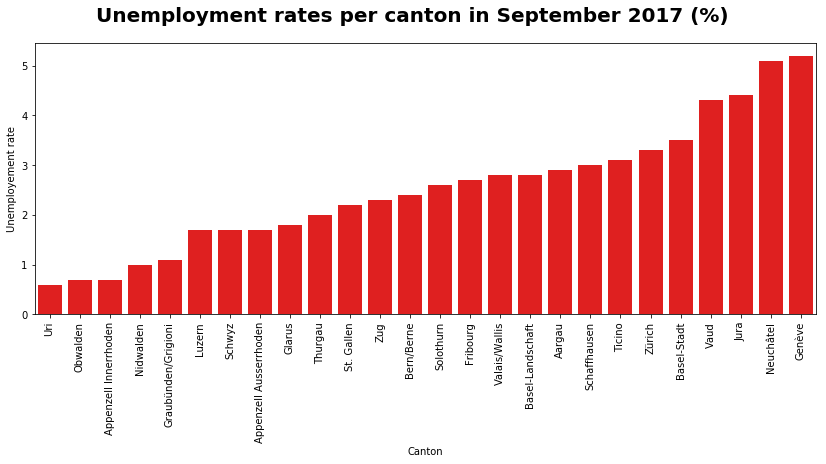

In [30]:
unemployement_rates_data_sorted = unemployement_rates_data.sort_values('Unemployement rate')
ax = plt.figure(figsize = (14,5))
g = sns.barplot(x = 'Canton', y = 'Unemployement rate', data = unemployement_rates_data_sorted[['Canton','Unemployement rate']], color ='Red')
g.set_xticklabels(labels = unemployement_rates_data_sorted['Canton'], rotation=90)
ax.suptitle("Unemployment rates per canton in September 2017 (%)", fontsize=20, fontweight="bold")
ax

With this first analysis, it is not trivial to draw a lot of trends in the repartition of unemployement in Switzerland. Nevertheless, we see that the rates are higher in the cantons bordering France and Germany, maybe because French and German people use their geographic position to work in Switzerland, make a lot of money and still Swiss people jobs. However, in the middle and in the east of Siwtzerland the rates are quiet low.

**PART 2: Data analysis of jobseekers rates and employed jobseekers rates**


**1- Loading data on jobseekers and employed jobseekers numbers by canton in Switzerland** <br>
The following loaded csv file was created through the amstat website https://www.amstat.ch/v2/index.jsp, Details section where we selected the 'Chômeurs et demandeurs d'emploi' folder and then 'Taux de chômage' folder. We are then asked to chose parameters before being given a data file with relative information on the selected parameters. 
Therefore, to produce this second csv file we chose the following parameters:
- Période sous revue sélectionner: 'Mois sous revue'
- Indicateurs taux de chômage: 'Taux de chômage'
- Indicateurs chômeurs: 'Chômeurs inscrits'
- Indicateurs demandeurs d'emploi: 'Demandeurs d'emploi', 'Demandeurs d'emploi non chômeurs'
- Caractéristiques géographiques: 'Canton'
- Optionnel: Restreindre les données géographiques à un ou plusieurs cantons: None
- Autres attributs: None

With these parameters, we are given a data file with information on the unemployement rates by canton which represents the number of unemployed people divided by the active population numbers, multiplied by 100. But we also have the numbers of unemployed people, jobseekers and employed jobseekers. Note that the jobseekers numbers are the sum of unemployed people and employed jobseekers.<br><br>
To read the data correctly, we use the character encoding library **chardet**.

In [31]:
unemployement_numbers_file = 'data/unemployement_numbers.csv'

with open(unemployement_numbers_file, 'rb') as f2:
    result2 = chardet.detect(f2.read()) 

unemployement_numbers_data = pd.read_csv(unemployement_numbers_file, encoding=result['encoding'])

In [32]:
unemployement_numbers_data.head()

Canton     Mois   Septembre 2017   Septembre 2017.1     Septembre 2017.2  \
0           Mesures  Taux de chômage  Chômeurs inscrits  Demandeurs d'emploi   
1   Zurich      NaN              3.3             27'225               34'156   
2    Berne      NaN              2.4             13'658               18'385   
3  Lucerne      NaN              1.7              3'885                6'756   
4      Uri      NaN              0.6                112                  257   

                   Septembre 2017.3            Total            Total.1  \
0  Demandeurs d'emploi non chômeurs  Taux de chômage  Chômeurs inscrits   
1                             6'931              3.3             27'225   
2                             4'727              2.4             13'658   
3                             2'871              1.7              3'885   
4                               145              0.6                112   

               Total.2                           Total.3  
0  Demandeurs d'emploi  Demandeurs d'emploi non chômeurs  
1               34'156                             6'931  
2               18'385                             4'727  
3                6'756                             2'871  
4                  257                               145

**2- Jobseekers and employed jobseekers data pre processing**
- We drop the columns 'Mois' and the ones containing the word 'Total' which are not relevant for our analysis.
- We also drop the first line of the dataframe which contains the index names of some of the columns (we will rename the columns accordingly afterwards).
- After droping the first line, we need to reset the index.
- We rename the remaining columns according to what the numbers represent. In that case: the unemployement rates per canton, the unemployed people, the jobseekers and the employed jobseekers.
- We finally remove the ' character in the numbers of above last three mentioned columns and convert them to numeric for our analysis.

In [33]:
unemployement_numbers_data.drop(['Mois'], axis=1, inplace = True)
unemployement_numbers_data = unemployement_numbers_data[unemployement_numbers_data.columns.drop(list(unemployement_numbers_data.filter(regex='Total')))]

In [34]:
unemployement_numbers_data.drop([0,unemployement_numbers_data.index.size-1], axis=0, inplace = True)
unemployement_numbers_data.reset_index(drop = True, inplace = True)

In [35]:
unemployement_numbers_data.dtypes

Canton              object
Septembre 2017      object
Septembre 2017.1    object
Septembre 2017.2    object
Septembre 2017.3    object
dtype: object

In [36]:
unemployement_numbers_data = unemployement_numbers_data.rename(columns={'Septembre 2017' : 'Unemployement rate', 
                                                                    'Septembre 2017.1' : 'Unemployed',
                                                                    'Septembre 2017.2' : 'Jobseekers',
                                                                    'Septembre 2017.3' : 'Employed jobseekers'})

In [37]:
unemployement_numbers_data['Unemployed'] = unemployement_numbers_data['Unemployed'].str.replace("'",'')

In [38]:
unemployement_numbers_data['Jobseekers'] = unemployement_numbers_data['Jobseekers'].str.replace("'",'')

In [39]:
unemployement_numbers_data['Employed jobseekers'] = unemployement_numbers_data['Employed jobseekers'].str.replace("'",'')

In [40]:
unemployement_numbers_data['Unemployement rate'] = pd.to_numeric(unemployement_numbers_data['Unemployement rate'])
unemployement_numbers_data['Unemployed'] = pd.to_numeric(unemployement_numbers_data['Unemployed'])
unemployement_numbers_data['Jobseekers'] = pd.to_numeric(unemployement_numbers_data['Jobseekers'])
unemployement_numbers_data['Employed jobseekers'] = pd.to_numeric(unemployement_numbers_data['Employed jobseekers'])

In [41]:
unemployement_numbers_data.head()

Canton  Unemployement rate  Unemployed  Jobseekers  Employed jobseekers
0   Zurich                 3.3       27225       34156                 6931
1    Berne                 2.4       13658       18385                 4727
2  Lucerne                 1.7        3885        6756                 2871
3      Uri                 0.6         112         257                  145
4   Schwyz                 1.7        1455        2229                  774

**3- Calculating the active population for each canton and the jobseekers and employed jobseekers rates**<br>
We are interested in calucating and analyzing the rates for different metrics but in this case we have numbers. 
We know that the way to calculate the unemployement rate is done in the following way:<br><br>
*Unemployement rate = Number of unemployed people / Number of active population x 100* <br><br>
Thus, to retrieve the rates for registered jobseekers and registered employed jobseekers we will have to do the follwing operations:<br><br>
*Jobseekers rate = Number of jobseekers / Number of active population x 100* <br>
*Employed jobseekers rate = Number of employed jobseekers / Number of active population x 100* <br><br>
The only missing value is the active population which we can retrieve from the first operation: <br><br>
*Number of active population = Number of unemployed people / Unemployement rate x 100*

In [42]:
unemployement_numbers_data['Active population'] = round(unemployement_numbers_data['Unemployed'] * 100 / unemployement_numbers_data['Unemployement rate'])

In [43]:
unemployement_numbers_data['Jobseekers rate'] = round(unemployement_numbers_data['Jobseekers'] * 100 / unemployement_numbers_data['Active population'],1)

In [44]:
unemployement_numbers_data['Employed jobseekers rate'] = round(unemployement_numbers_data['Employed jobseekers'] * 100 / unemployement_numbers_data['Active population'],1)

In [45]:
unemployement_numbers_data.head()

Canton  Unemployement rate  Unemployed  Jobseekers  Employed jobseekers  \
0   Zurich                 3.3       27225       34156                 6931   
1    Berne                 2.4       13658       18385                 4727   
2  Lucerne                 1.7        3885        6756                 2871   
3      Uri                 0.6         112         257                  145   
4   Schwyz                 1.7        1455        2229                  774   

   Active population  Jobseekers rate  Employed jobseekers rate  
0           825000.0              4.1                       0.8  
1           569083.0              3.2                       0.8  
2           228529.0              3.0                       1.3  
3            18667.0              1.4                       0.8  
4            85588.0              2.6                       0.9

**4- We create two separate dataframes one with jobseekers rates and the other with employed jobseekers rates**<br>
For both of them, we rename the canton's names with the ones from the topojson file.

In [46]:
columns = ['Canton','Jobseekers rate']
jobseekers_rates_data = unemployement_numbers_data[columns]

In [47]:
columns = ['Canton','Employed jobseekers rate']
employed_jobseekers_rates_data = unemployement_numbers_data[columns]

In [48]:
jobseekers_rates_data.Canton = canton_geo_df.name

/anaconda/envs/ada/lib/python3.5/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [49]:
employed_jobseekers_rates_data.Canton = canton_geo_df.name

/anaconda/envs/ada/lib/python3.5/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


**5- Jobseekers rates analysis**<br>
In the same way we have done it with the unemployement rates we create a choropleth map to display Swiss cantons' jobseekers rates information
- We have chosen the coordinates of the middle of Switzerland to center our map. 
- Then, we initialize our map with these coordinates and make it a choropleth map with the topojson information converted to json in the previous steps after pre processing of the Cantons' names and we use the data on jobseekers rates to be displayed accordingly. We use a Yellow (low jobseekers rate) to Green (high jobseekers rate) sequential color which is by default divided into 6 equal intervals in the range of our jobseekers rates values by folium. 
- Finally, we create again strings for each canton to display info on the rates in pop ups windows.

In [50]:
swiss_map_jobseekers_rates = folium.Map(middle_of_switzerland_coord, tiles='cartodbpositron', zoom_start = 8)
swiss_map_jobseekers_rates.choropleth(geo_data=canton_geo_to_json,
              data=jobseekers_rates_data, columns=['Canton', 'Jobseekers rate'],
                     key_on='feature.properties.name', fill_color='YlGn', fill_opacity=1, line_opacity=0.2,
             legend_name='Jobseeekers Rate (%)')

In [51]:
text2 = []
for i in range(jobseekers_rates_data.index.size):
    text2.append(jobseekers_rates_data.Canton[i] +  '<br>' + 
                'Jobseekers rate: ' + str(jobseekers_rates_data['Jobseekers rate'].loc[i]) + '%')

In [52]:
list_geo=[]
gj=[]
for i in range(canton_geo_gdf.index.size):
     list_geo.append(mapping(canton_geo_gdf['geometry'].loc[i]))
     gj.append(folium.GeoJson(list_geo[i], style_function=lambda feature: {
        'opacity' : 0.7 , 'fillColor': '#FFFFFFFF', 'color' : 'blue'
        }))

In [53]:
for i in range(canton_geo_df.index.size):
    gj[i].add_child(folium.Popup(text2[i]))
    gj[i].add_to(swiss_map_jobseekers_rates)

In [54]:
swiss_map_jobseekers_rates

**6- Histogram of jobseekers rates by canton**<br>
Again, before ending our analysis on jobseekers rates by canton we also display an histogram to have another view of these rates according to the different cantons. Values of jobseekers rates are again sorted in ascending order and displayed afterwards.

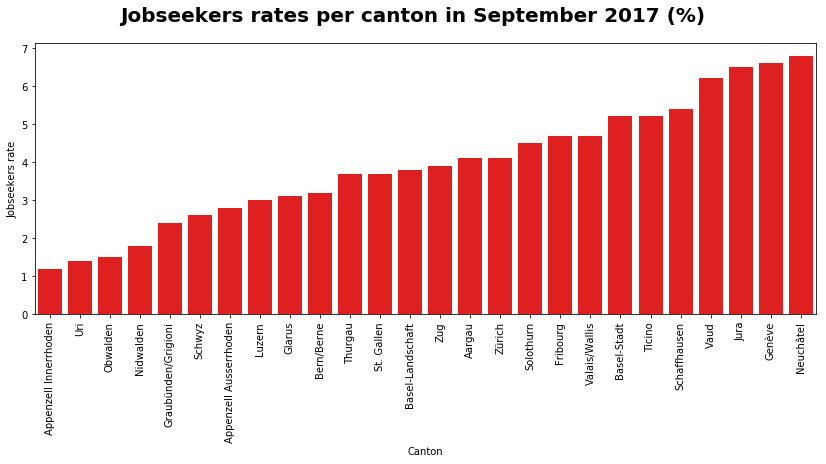

In [55]:
jobseekers_rates_data_sorted = jobseekers_rates_data.sort_values('Jobseekers rate')
ax = plt.figure(figsize = (14,5))
g = sns.barplot(x = 'Canton', y = 'Jobseekers rate', data = jobseekers_rates_data_sorted[['Canton','Jobseekers rate']], color ='Red')
g.set_xticklabels(labels = jobseekers_rates_data_sorted['Canton'], rotation=90)
ax.suptitle("Jobseekers rates per canton in September 2017 (%)", fontsize=20, fontweight="bold")
ax

In [56]:
swiss_map_jobseekers_rates.save(os.path.join('maps', 'jobseekers_rates_by_canton.html'))

**7- Employed jobseekers rates analysis**<br>
For the last time we create a choropleth map to display Swiss cantons' employed jobseekers rates information
- We have chosen the coordinates of the middle of Switzerland to center our map. 
- Then, we initialize our map with these coordinates and make it a choropleth map with the topojson information converted to json in the previous steps after pre processing of the Cantons' names and we use the data on employed jobseekers rates to be displayed accordingly. We use a Yellow (low employed jobseekers rate) to Green (high employed jobseekers rate) sequential color which is by default divided into 6 equal intervals in the range of our employed jobseekers rates values by folium. 
- Finally, we create again strings for each canton to display info on the rates in pop ups windows.

In [57]:
swiss_map_employed_jobseekers_rates = folium.Map(middle_of_switzerland_coord, tiles='cartodbpositron', zoom_start = 8)
swiss_map_employed_jobseekers_rates.choropleth(geo_data=canton_geo_to_json,
              data=employed_jobseekers_rates_data, columns=['Canton', 'Employed jobseekers rate'],
                     key_on='feature.properties.name', fill_color='YlGn', fill_opacity=1, line_opacity=0.2,
             legend_name='Employed jobseeekers Rate (%)')

In [58]:
text3 = []
for i in range(employed_jobseekers_rates_data.index.size):
    text3.append(employed_jobseekers_rates_data.Canton[i] +  '<br>' + 
                'Employed jobseekers rate: ' + str(employed_jobseekers_rates_data['Employed jobseekers rate'].loc[i]) + '%')

In [59]:
list_geo=[]
gj=[]
for i in range(canton_geo_gdf.index.size):
     list_geo.append(mapping(canton_geo_gdf['geometry'].loc[i]))
     gj.append(folium.GeoJson(list_geo[i], style_function=lambda feature: {
        'opacity' : 0.7 , 'fillColor': '#FFFFFFFF', 'color' : 'blue'
        }))

In [60]:
for i in range(canton_geo_df.index.size):
    gj[i].add_child(folium.Popup(text3[i]))
    gj[i].add_to(swiss_map_employed_jobseekers_rates)

In [61]:
swiss_map_employed_jobseekers_rates

In [62]:
swiss_map_employed_jobseekers_rates.save(os.path.join('maps', 'employed_jobseekers_rates_by_canton.html'))

**8- Histogram of employed jobseekers rates by canton**<br>
Finally, before ending our analysis on employed jobseekers rates by canton we also display an histogram to have another view of these rates according to the different cantons. Values of employed jobseekers rates are again sorted in ascending order and displayed afterwards.

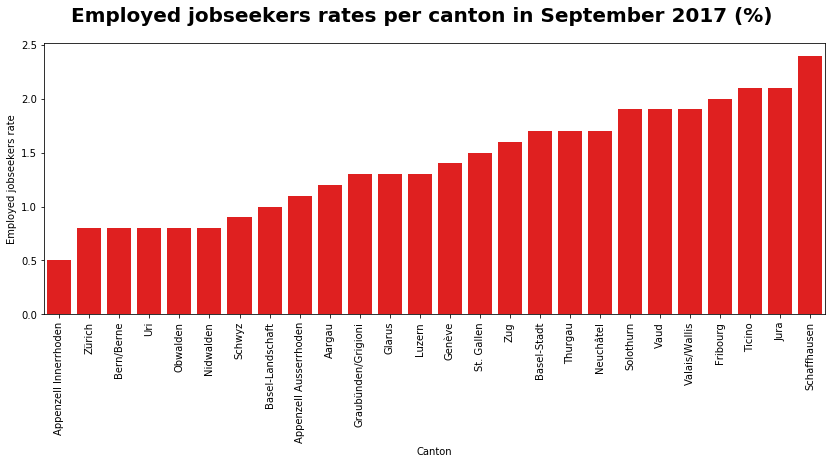

In [63]:
employed_jobseekers_rates_data_sorted = employed_jobseekers_rates_data.sort_values('Employed jobseekers rate')
ax = plt.figure(figsize = (14,5))
g = sns.barplot(x = 'Canton', y = 'Employed jobseekers rate', data = employed_jobseekers_rates_data_sorted[['Canton','Employed jobseekers rate']], color ='Red')
g.set_xticklabels(labels = employed_jobseekers_rates_data_sorted['Canton'], rotation=90)
ax.suptitle("Employed jobseekers rates per canton in September 2017 (%)", fontsize=20, fontweight="bold")
ax

**Results interpretation:**<br> 
From the three generated maps and the histograms displayed, we can observe several interesting trends.
- First of all, the unemployement rates which represents only the unemployed people is close to the jobseekers rate. Indeed, the amount of employed jobseekers in this new rate does not affect the trends observed on the unemployement rate map. Genève, Neuchâtel, Jura and Vaud still are the cantons with the highest rates on both maps. While Appenzell Innerrhoden, Uri, Obwalden and Nidwalden remain the cantons with the lowest rates. The interesting fact to highlight here is that for the cantons with the highest rates, they all are bordering France. While three of the four cantons with the smallest rates are all in the middle of Switzerland. 
- On the other hand, we can observe that the map representing the employed jobseekers shows a little mix up on the trends. The cantons with highest and lowest rates mentionned above keep the same trend but for the other cantons we can see a little change in the values of their rate for this particular metric. But the most interesting trend to observe on this map is that the cantons with the lowest rates on the unemployement map tend to have a higher employed jobseekers rate than the actual unemployement rate. <br>

To assert our interpretations, we can compute a correlation matrix using the spearman method.

In [64]:
correlations = unemployement_numbers_data.corr(method = 'spearman')

In [65]:
correlations

Unemployement rate  Unemployed  Jobseekers  \
Unemployement rate                  1.000000    0.724162    0.652636   
Unemployed                          0.724162    1.000000    0.982906   
Jobseekers                          0.652636    0.982906    1.000000   
Employed jobseekers                 0.597194    0.957607    0.984957   
Active population                   0.525668    0.943932    0.975385   
Jobseekers rate                     0.962843    0.641464    0.588779   
Employed jobseekers rate            0.615047    0.299128    0.311506   

                          Employed jobseekers  Active population  \
Unemployement rate                   0.597194           0.525668   
Unemployed                           0.957607           0.943932   
Jobseekers                           0.984957           0.975385   
Employed jobseekers                  1.000000           0.978120   
Active population                    0.978120           1.000000   
Jobseekers rate                      0.542251           0.448854   
Employed jobseekers rate             0.329041           0.217298   

                          Jobseekers rate  Employed jobseekers rate  
Unemployement rate               0.962843                  0.615047  
Unemployed                       0.641464                  0.299128  
Jobseekers                       0.588779                  0.311506  
Employed jobseekers              0.542251                  0.329041  
Active population                0.448854                  0.217298  
Jobseekers rate                  1.000000                  0.781190  
Employed jobseekers rate         0.781190                  1.000000

From these numbers, we see that indeed the jobseekers rate is more correlated with the unemployement rate than to the employed jobseekers rate. Which explains the very little difference between the two maps. 
However, we see that the correlation between the unemployement rate and the employed jobseekers rate is about 0.6 which does not testify of a strong correlation between these two rates. It can justify of the little changes observed on the third map.